# GTA V Racebot via Behavioural Cloning

This notebook trains a racebot for GTA V for a simple race track (https://www.gta5-mods.com/maps/formula-1-formula-e-circuit). We use behavioural cloning from imitation learning, in which the model learns a policy by mimicking the demonstrations (i.e., transforms the problem to a supervised learning problem). The states are defined as the speed of the car & raycast distances & the actions are discrete values for throttle & steering.   

1. EDA
2. Train
3. Conclusion

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

2025-11-15 17:16:45.345169: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763227005.608597      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763227005.683645      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [2]:
FILE_PATH = '/kaggle/input/racing-data-bc-1/racing_data_20251111_115450.csv'

### 1. EDA

We must look for imbalances in the labels, since the track has long straights, our data will have less turn data. 

In [3]:
df = pd.read_csv(FILE_PATH, index_col=False)
print(f"Samples: {len(df)}")
print(df.head())
print(df.describe())

Samples: 84286
      speed    ray_0    ray_1    ray_2    ray_3    ray_4    ray_5    ray_6  \
0  0.006423  13.3434  17.9467  33.5831  79.1044  29.4587  15.6063  11.5635   
1  0.006048  13.3434  17.9468  33.5835  79.1041  29.4584  15.6063  11.5635   
2  0.006314  13.3434  17.9467  33.5832  79.1041  29.4584  15.6063  11.5635   
3  0.006494  13.3434  17.9467  33.5832  79.1044  29.4587  15.6063  11.5635   
4  0.006364  13.3434  17.9467  33.5832  79.1044  29.4587  15.6063  11.5635   

   steering  throttle  
0       0.0       0.0  
1       0.0       0.0  
2       0.0       0.0  
3       0.0       0.0  
4       0.0       0.0  
              speed         ray_0         ray_1         ray_2         ray_3  \
count  84286.000000  84286.000000  84286.000000  84286.000000  84286.000000   
mean      40.815017     13.415752     18.091388     42.415051     87.546020   
std        5.639448      9.768494     10.486268     24.504446     32.479647   
min        0.003145      2.576450      3.434760      6.3

In [4]:
df = df[df['speed'] > 5.0] # get rid of crashes or stationary
print(f"Samples: {len(df)}")

Samples: 84133


In [5]:
print(f"Left turns (< -0.1): {(df['steering'] < -0.1).sum()}")
print(f"Straight (±0.1): {(df['steering'].abs() <= 0.1).sum()}")
print(f"Right turns (> 0.1): {(df['steering'] > 0.1).sum()}")

Left turns (< -0.1): 15491
Straight (±0.1): 59781
Right turns (> 0.1): 8861


In [6]:
straight = df[df['steering'].abs() < 0.1]
turning = df[df['steering'].abs() >= 0.1]

if len(straight) > len(turning) * 2:
    straight_sampled = straight.sample(n=len(turning) * 2, random_state=42)
    df = pd.concat([straight_sampled, turning])
    df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    print(f"After balancing: {len(df)}")

After balancing: 73056


In [7]:
throttle_on = df[df['throttle'] > 0.1]
throttle_off = df[df['throttle'] <= 0.1]

In [8]:
if len(throttle_on) > len(throttle_off) * 2:
    throttle_on_sampled = throttle_on.sample(n=len(throttle_off) * 2, random_state=42)
    df = pd.concat([throttle_on_sampled, throttle_off])
    print(f"After balancing: {len(df)}")

After balancing: 27606


### 2. Training

We will create a simple MLP w/ just 2 layers. 

In [9]:
X = df[['speed', 'ray_0', 'ray_1', 'ray_2', 'ray_3', 'ray_4', 'ray_5', 'ray_6']].values
y = df[['steering', 'throttle']].values

In [10]:
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

print(scaler_X.mean_)
print(scaler_X.scale_)

[40.31387887 13.3171938  17.94204432 44.73560258 77.80768833 35.56498163
 16.78186832 12.84412013]
[ 5.47637981  9.25261478  9.72122038 24.71908633 32.80978699 18.13965501
  4.19510602  5.41073173]


In [11]:
import joblib
joblib.dump(scaler_X, 'scaler.pkl')

print(scaler_X.mean_)
print(scaler_X.scale_)

[40.31387887 13.3171938  17.94204432 44.73560258 77.80768833 35.56498163
 16.78186832 12.84412013]
[ 5.47637981  9.25261478  9.72122038 24.71908633 32.80978699 18.13965501
  4.19510602  5.41073173]


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [22]:
model = keras.Sequential([
    keras.layers.Input(shape=(8,)),  # speed + 7 rays
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.3),
    
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    
    # tanh for steering (-1 to 1), sigmoid for throttle (0 to 1)
    keras.layers.Dense(2, activation='linear')  # we'll split outputs
])

In [23]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,882 (26.88 KB)

 Trainable params: 6,882 (26.88 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
early_stop = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2429 - mae: 0.3737 - val_loss: 0.1314 - val_mae: 0.2881
Epoch 2/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1481 - mae: 0.3034 - val_loss: 0.1221 - val_mae: 0.2713
Epoch 3/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1324 - mae: 0.2827 - val_loss: 0.1157 - val_mae: 0.2683
Epoch 4/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1265 - mae: 0.2729 - val_loss: 0.1093 - val_mae: 0.2550
Epoch 5/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1186 - mae: 0.2585 - val_loss: 0.1049 - val_mae: 0.2390
Epoch 6/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1158 - mae: 0.2523 - val_loss: 0.1029 - val_mae: 0.2391
Epoch 7/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1135 - mae: 0.2489 - val_loss: 0.1007 - val_mae: 0.2273
Epoch 8/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1105 - mae: 0.2426 - val_loss: 0.0989 - val_mae: 0.2279
Epoch 9/50
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - lo

### 3. Conclusion 

These values are expected. 

In [16]:
y_pred = model.predict(X_test)

y_pred_steering = np.tanh(y_pred[:, 0])  # Steering: -1 to 1
y_pred_throttle = np.clip(y_pred[:, 1], 0, 1)  # Throttle: 0 to 1

y_pred_final = np.column_stack([y_pred_steering, y_pred_throttle])

steering_mae = np.mean(np.abs(y_test[:, 0] - y_pred_final[:, 0]))
throttle_mae = np.mean(np.abs(y_test[:, 1] - y_pred_final[:, 1]))

print(f"Steering MAE: {steering_mae:.4f}")
print(f"Throttle MAE: {throttle_mae:.4f}")

173/173 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Steering MAE: 0.2397
Throttle MAE: 0.1614


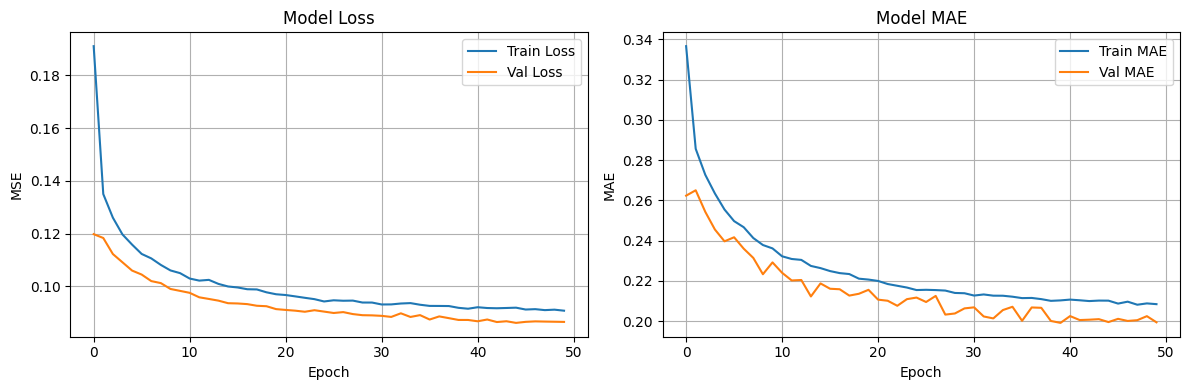

In [17]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_history.png')
plt.show()

In [18]:
model.save("model.keras")